# Python script for a spatial explorations of the EDH dataset
*Created by: Vojtech Kase*


Requirements:
*   Google Colab account 
*   Access to Sciencedata.dk or access alternatively to the dataset in JSON
*   Basic knowledge of Python (how to run scripts in Python notebooks)



# Requirements

In [1]:
### GENERAL REQUIREMENTS - will install the libraries
import numpy as np
import math
import pandas as pd
from google.colab import files ### to interact between google colab and local harddrive
import sys
import requests
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import json # the input data have typically a json structure
import getpass
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

!pip install sddk ### our own package under construction, always install to have an up-to-date version
import sddk

There is a number of additional packages for working with spatial data, which require individual installation

In [0]:
### some advanced spatial indexing requires libspatialindex library based on C
#### libspatialindex is used by Rtree

### to use it in google colab, use the following script
### for an explanation see: https://stackoverflow.com/questions/48293601/how-to-install-libspatialindex-on-google-collaboratory

### a magic to hide cell output
%%capture

### a rather complex thing:
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz 2>/dev/null | tar xz
!apt-get install -qq g++ make
import os
os.chdir('/content/spatialindex-src-1.8.5')
!mount -o remount,exec /content
!./configure 2>&1 >/dev/null && make 2>&1 >/dev/null && make install && ldconfig
!pip install -q rtree
from rtree import index
from rtree.index import Rtree

In [0]:
### other packages for working with spatial data

### a magic to hide cell output
%%capture
!pip install contextily==1.0rc2
import contextily as ctx # basemaps
import shapely # geometries, e.g. "POINT (23931.23 45492.17)"
!pip install geopandas==0.6.2 ### for some reasons, 0.6.3 does not work, so let's force 0.6.2
import geopandas # pandas DataFrame + geometry
!pip install pyshp
import shapefile # to work with shapefiles
#!pip install pysal # to parametrize colorscale maps, it is somehow above mapclassify
#import pysal 
#!pip install mapclassify # to parametrize colorscale maps
#import mapclassify

## Establish connection with sciencedata.dk: configure session and shared folder URL

In [3]:
### configure session and groupurl
### in the case of "SDAM_root", the folder owner is Vojtech with username 648597@au.dk
conf = sddk.configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Reading Roman provinces data from shapefiles located on web

there is a lot of relevant shapefiles dispersed through the internet. For political borders of the Roman Empire, see [this](http://awmc.unc.edu/awmc/map_data/shapefiles/cultural_data/political_shading/). Check also this link for many other interesting datasets: https://projectmercury.eu/datasets/.

Unfortunately, I (Vojtech) still cannot find a database with Roman provinces including names of the provinces. Perhaps I just do not know where to look for it.

In [4]:
### (1) READ THE SHAPEFILE INTO A READER OBJECT

### here we rely on pyshp (or "shapefile") and its Reader() function
### to properly read a shapefile, you need access at least to the ".shp" file and the ".dbf" file
url_raw_filename = "http://awmc.unc.edu/awmc/map_data/shapefiles/cultural_data/political_shading/roman_empire_ad_117/shape/roman_empire_ad_117"
file_shp = urlopen(url_raw_filename + ".shp")
file_dbf = urlopen(url_raw_filename + ".dbf")
reader = shapefile.Reader(shp=file_shp, dbf=file_dbf) ### see https://pypi.org/project/pyshp/#reading-shapefiles-from-file-like-objects
### now we have a reader object to iterate over
len(reader.records())

111

In [5]:
### (2) GENERATE A GEODATAFRAME FROM THE READER OBJECT

### based on https://gist.github.com/frankrowe/6071443
features = []
field_names = [field[0] for field in reader.fields[1:]]
for element in reader.shapeRecords():
  atr = dict(zip(field_names, element.record))
  geo = element.shape.__geo_interface__
  features.append(dict(type="Feature", geometry=geo, properties=atr))

provinces = geopandas.GeoDataFrame.from_features(features)
provinces.head()

,geometry,OBJECTID,AREA,PERIMETER,NEWDIO_,NEWDIO_ID,ID,Shape_Leng,Shape_Area
0,"POLYGON ((-1.57431 55.16792, -1.50632 54.98433...",1,19.612703,35.387086,2,0,0,35.115167,19.325197
1,"POLYGON ((-4.59302 54.30514, -4.56152 54.34428...",2,0.080670,1.212228,3,0,0,1.212228,0.080670
2,"POLYGON ((-0.57376 53.75199, -0.60391 53.70755...",3,0.006408,0.311314,4,0,0,0.311314,0.006408
3,"POLYGON ((-4.60976 53.31895, -4.57282 53.35276...",4,0.092548,1.281687,5,0,0,1.281687,0.092548
4,"POLYGON ((1.68338 52.73775, 1.75385 52.69902, ...",5,0.005562,0.312915,6,0,0,0.312915,0.005562


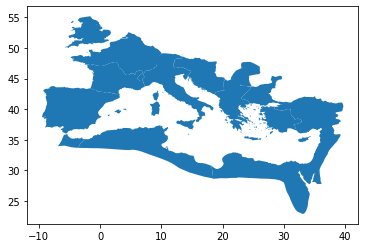

In [0]:
provinces.plot()

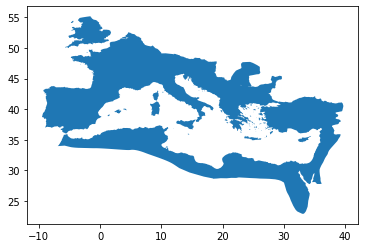

In [0]:
### ROMAN EMPIRE AS A WHOLE (merged)

### merge polygons into one aka groupyby
RE = provinces.dissolve(by="ID")
RE.reset_index(inplace=True)
RE.plot()

## EDH dataset from sciencedata.dk


In [0]:
### Once the connection has been succesfuilly established, we can upload the data from sciencedata into Pandas dataframe
### Look at Pandas documention to learn how to navigate Pandas dataframe with their endless functionality: https://pandas.pydata.org/pandas-docs/version/0.23.4/index.html
EDH_df = sddk.read_file("SDAM_data/EDH/EDH_inscriptions_rich.json", "df", conf)
EDH_df.set_index("id", inplace=True) ### perhaps the best index is the "ID" # Vojtech: Why? As a user I am not sure why we need to index? - answer: once you have data with your own index column, it makes some queries in pandas a little bit simpler, for instance, to explore particular inscription, you can easily run EDH_df.loc["HD000004"]
EDH_df.head(5) ### use ".head(5)" to inspect first 5 rows of the dataframe

,diplomatic_text,literature,trismegistos_uri,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,coordinates,text_cleaned,origdate_text,objecttype
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HD000001,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"[{'cognomen': 'Optata', 'person_id': '1', 'gen...",None,None,None,None,None,None,None,None,None,"40.8471577,14.0550756",Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"[Tafel, 257]"
HD000002,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,None,AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"[{'age: years': '70', 'cognomen': 'Paris', 'ge...",1937,"Via Nomentana, S. Alessandro, Kirche",None,None,None,None,None,None,None,"41.895466,12.482324",Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"[Tafel, 257]"
HD000003,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,None,0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"[{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ R...",before 1975,None,"Sevilla, Privatbesitz",None,None,None,None,None,None,"37.37281,-6.04589",Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,"[Statuenbasis, 57]"
HD000004,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 cm,Material: lokaler grauer Kalkstein. (B): Styl...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Gräf,2015-03-27,Latin,Córdoba,2.5 cm,altar,"[{'cognomen': '[---]', 'status': 'slaves', 'pe...",before 1979,None,"Carcabuey, Grupo Escolar",[http://cil-old.bbaw.de/test06/bilder/datenban...,names of pagan deities,None,None,None,None,"37.4442,-4.27471",AVSLLA Marci Porci Nigri serva dominae Veneri ...,151 AD – 200 AD,"[Altar, 29]"
HD000005,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265629,Roma,0001,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,[---] l(ibertus) Successus / [---] L(uci) l(ib...,None,None,None,Roma,None,(B): Z. 3: C(ai) l(ibertae) Tyches.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2010-01-04,Latin,Lazio,None,stele,"[{'st

# EDH as GeoDataframe

In [0]:
### make GeoDataFrame geometry
def set_coordinate(row, zero_or_two):
  try:
    coor = float(row["coordinates"].partition(",")[zero_or_two])
  except:
    coor = 0
  return float(coor)
EDH_df["x"] = EDH_df.apply(lambda row: set_coordinate(row, 2), axis=1)
EDH_df["y"] = EDH_df.apply(lambda row: set_coordinate(row, 0), axis=1)
EDH_gdf = geopandas.GeoDataFrame(EDH_df, geometry = geopandas.points_from_xy(x=EDH_df["x"], y=EDH_df["y"]))
EDH_gdf.drop(columns=["coordinates", "x", "y"], inplace=True)
EDH_gdf.head(5)

,diplomatic_text,literature,trismegistos_uri,findspot_ancient,not_before,type_of_inscription,work_status,edh_geography_uri,not_after,country,province_label,transcription,material,height,width,findspot_modern,depth,commentary,uri,responsible_individual,last_update,language,modern_region,letter_size,type_of_monument,people,year_of_find,findspot,present_location,external_image_uris,religion,fotos,geography,military,social_economic_legal_history,text_cleaned,origdate_text,objecttype,geometry
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HD000001,D M / NONIAE P F OPTATAE / ET C IVLIO ARTEMONI...,"AE 1983, 0192.; M. Annecchino, Puteoli 4/5, 19...",https://www.trismegistos.org/text/251193,"Cumae, bei",0071,epitaph,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0130,Italy,Latium et Campania (Regio I),D(is) M(anibus) / Noniae P(ubli) f(iliae) Opta...,"Marmor, geädert / farbig",33 cm,34 cm,"Cuma, bei",2.7 cm,(C): 2. Hälfte 1. - Anfang 2. Jh. - AE; Ende ...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Campania,3.2-2 cm,tabula,"[{'cognomen': 'Optata', 'person_id': '1', 'gen...",None,None,None,None,None,None,None,None,None,Dis Manibus Noniae Publi filiae Optatae et Cai...,71 AD – 130 AD,"[Tafel, 257]",POINT (14.05508 40.84716)
HD000002,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265631,Roma,0051,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,C(aius) Sextius Paris / qui vixit / annis LXX,marble: rocks - metamorphic rocks,28 cm,85 cm,Roma,None,AE 1983: Breite: 35 cm.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2014-04-07,Latin,Lazio,4 cm,tabula,"[{'age: years': '70', 'cognomen': 'Paris', 'ge...",1937,"Via Nomentana, S. Alessandro, Kirche",None,None,None,None,None,None,None,Caius Sextius Paris qui vixit annis LXX ...,51 AD – 200 AD,"[Tafel, 257]",POINT (12.48232 41.89547)
HD000003,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",https://www.trismegistos.org/text/220675,None,0131,honorific inscription,provisional,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0170,Spain,Baetica,[P(ublio) M]ummio [P(ubli) f(ilio)] / [Gal(eri...,marble: rocks - metamorphic rocks,(37) cm,(34) cm,Tomares,(12) cm,(B): [S]isenna ist falscher Kasus; folgende E...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2006-08-31,Latin,Sevilla,4.5-3 cm,statue base,"[{'nomen': 'Mummius+', 'cognomen': 'Sisenna+ R...",before 1975,None,"Sevilla, Privatbesitz",None,None,None,None,None,None,Publio Mummio Publi filio Galeria Sisennae Rut...,131 AD – 170 AD,"[Statuenbasis, 57]",POINT (-6.04589 37.37281)
HD000004,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",https://www.trismegistos.org/text/222102,Ipolcobulcula,0151,votive inscription,checked with photo,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Spain,Baetica,[---?]AV(?)S(?)[---]L(?)L(?)A / M(arci) Porci ...,limestone: rocks - clastic sediments,(39) cm,27 cm,Carcabuey,18 cm,Material: lokaler grauer Kalkstein. (B): Styl...,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Gräf,2015-03-27,Latin,Córdoba,2.5 cm,altar,"[{'cognomen': '[---]', 'status': 'slaves', 'pe...",before 1979,None,"Carcabuey, Grupo Escolar",[http://cil-old.bbaw.de/test06/bilder/datenban...,names of pagan deities,None,None,None,None,AVSLLA Marci Porci Nigri serva dominae Veneri ...,151 AD – 200 AD,"[Altar, 29]",POINT (-4.27471 37.44420)
HD000005,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",https://www.trismegistos.org/text/265629,Roma,0001,epitaph,no image,https://edh-www.adw.uni-heidelberg.de/edh/geog...,0200,Italy,Roma,[---] l(ibertus) Successus / [---] L(uci) l(ib...,None,None,None,Roma,None,(B): Z. 3: C(ai) l(ibertae) Tyches.,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Feraudi,2010-01-04,Latin,Lazio,N

# Orbis Transportation Network (from online geojson)

In [0]:
### add orbis transportation network
url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/base_routes.geojson"
orbis = geopandas.read_file(url)
orbis.head()

,gid,sid,tid,t,e,s,geometry
0,559512,50001,50056,road,1.91,1.82,"LINESTRING (10.89500 48.36500, 10.89344 48.354..."
1,558621,50001,50100,road,1.75,1.67,"LINESTRING (10.32700 47.72700, 10.33948 47.738..."
2,559794,50001,50293,road,2.30,2.19,"LINESTRING (11.08600 47.49200, 11.10305 47.505..."
3,560116,50001,50473,road,7.89,7.51,"LINESTRING (11.17000 46.66000, 11.16163 46.679..."
4,558775,50002,50275,road,3.23,3.07,"LINESTRING (41.24466 37.07815, 41.27515 37.077..."


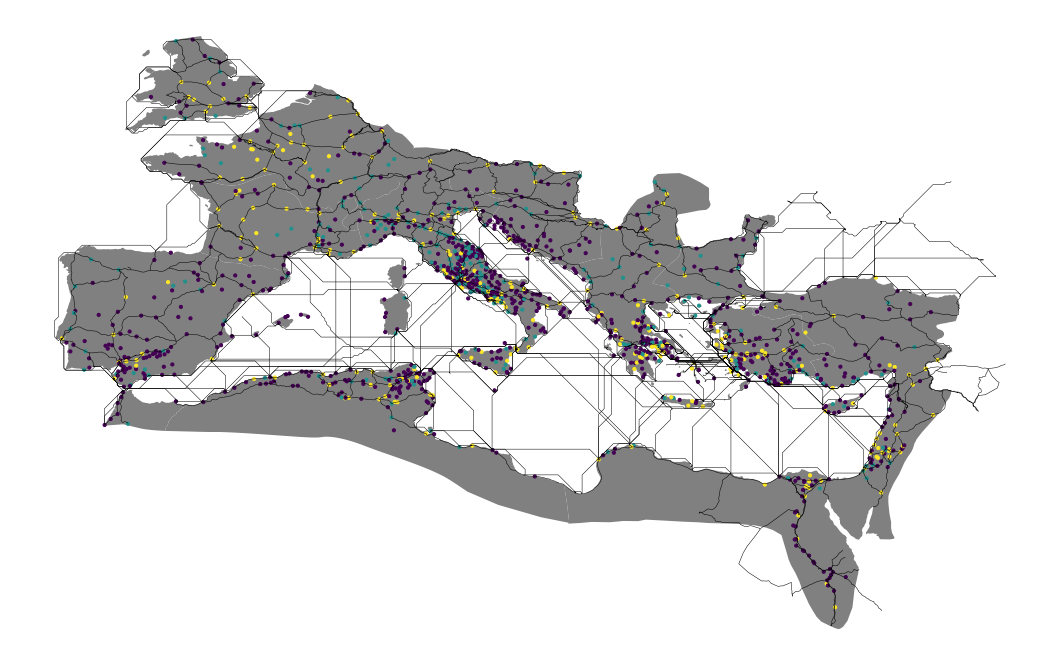

In [0]:
# Make a plot with basemap
plt.rcParams['figure.figsize'] = [24, 12]
fig, ax = plt.subplots()
provinces.plot(color="grey", ax=ax)
orbis.plot(color="black", linewidth=0.5 , ax=ax)
#EDH_gdf.plot(markersize=0.5, color="blue", ax=ax) 
cities.plot(column="Area", cmap='viridis', scheme="quantiles", k=5, markersize=10, ax=ax)
#ctx.add_basemap(ax=ax,  zoom=6, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326")
plt.axis("off")
plt.show()

AttributeError: ignored

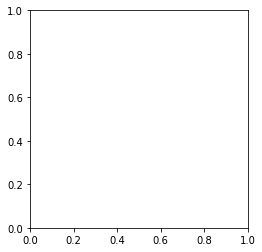

In [0]:
cities.plot(column="num_of_structures", cmap='YlOrBr', scheme="quantiles", k=15)

In [0]:
cities[cities["Civic Status"]>5].tail(30)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Notes,Structure,geometry
25,Hanson2016_26,Corinthia,Corinth,Achaea,Greece,1,58 D2,-44,NaN,BNP; Boatwright 2000; Brunt 1971; Cornell and ...,241.0,Urban grid,7.0,3.0,56.0,POINT (22.87980 37.90632)
75,Hanson2016_76,Patrae,Patrai,Achaea,Greece,2,58 B1,-600,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,NaN,NaN,6.0,3.0,14.0,POINT (21.73707 38.25447)
171,Hanson2016_172,Carthago,Tunis,Africa Proconsularis,Tunisia,1,32 F3,-49,NaN,Bomgardner 2000; Brunt 1971; Cornell and Mathe...,343.0,Inhabited area,6.0,2.0,19.0,POINT (10.32769 36.85132)
177,Hanson2016_178,Hadrumetum,Sousse,Africa Proconsularis,Tunisia,3,33 G1,-150,NaN,BNP; Brunt 1971; DGRG; Lepelley 1979-1981; Mac...,156.0,Walls,6.0,3.0,14.0,POINT (10.63761 35.82498)
206,Hanson2016_207,Thuburbo Maius,Henchir Kasbat,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,BNP; Boatwright 2000; Bomgardner 2000; Brunt 1...,25.0,Inhabited area,6.0,2.0,20.0,POINT (9.90419 36.40086)
216,Hanson2016_217,Utica,Utique,Africa Proconsularis,Tunisia,3,32 F2,-400,NaN,BNP; Boatwright 2000; Bomgardner 2000; Brunt 1...,88.0,Inhabited area,12.0,6.0,14.0,POINT (10.03800 37.03580)
335,Hanson2016_336,Corduba,Córdoba,Baetica,Spain,1,26 F4,-152,NaN,Brunt 1971; Carreras Monfort 1995-1996; Cornel...,99.0,Urban grid and inhabited area,8.0,3.0,22.0,POINT (-4.78025 37.88376)
336,Hanson2016_337,Gades,Cádiz,Baetica,Spain,2,26 D5,-400,NaN,BNP; Brunt 1971; Carreras Monfort 1995-1996; C...,81.0,Inhabited area,9.0,5.0,10.0,POINT (-6.29241 36.52994)
346,Hanson2016_347,Italica,Santiponce,Baetica,Spain,3,26 D4,-206,NaN,Benario 1981; BNP; Boatwright 2000; Brunt 1971...,49.0,Walls,6.0,3.0,14.0,POINT (-6.04486 37.44111)
375,Hanson2016_376,Apamea (Bithynia et Pontus),Mudanya,Bithynia et Pontus,Turkey,3,52 D4,-500,NaN,BNP; Brunt 1971; Cohen 1995; Cornell and Mathe...,NaN,NaN,6.0,3.0,1.0,POINT (28.89110 40.36849)


# EDH + PROVINCES - Spatial Join

In [0]:
provinces.head(5)

,geometry,OBJECTID,AREA,PERIMETER,NEWDIO_,NEWDIO_ID,ID,Shape_Leng,Shape_Area
0,"POLYGON ((-1.57431 55.16792, -1.50632 54.98433...",1,19.612703,35.387086,2,0,0,35.115167,19.325197
1,"POLYGON ((-4.59302 54.30514, -4.56152 54.34428...",2,0.080670,1.212228,3,0,0,1.212228,0.080670
2,"POLYGON ((-0.57376 53.75199, -0.60391 53.70755...",3,0.006408,0.311314,4,0,0,0.311314,0.006408
3,"POLYGON ((-4.60976 53.31895, -4.57282 53.35276...",4,0.092548,1.281687,5,0,0,1.281687,0.092548
4,"POLYGON ((1.68338 52.73775, 1.75385 52.69902, ...",5,0.005562,0.312915,6,0,0,0.312915,0.005562


In [0]:
len(EDH_gdf)

80270

In [0]:
#### ADD PROVINCE NUMBER TO EDH_gdf

### geopandas.sjoin(df1, df2[[selected_col1, selected_col2]], op="within")
EDH_gdf = geopandas.sjoin(EDH_gdf, provinces[["geometry", "OBJECTID"]], op="within")

In [0]:
### now we have only inscriptions within provinces
len(EDH_gdf)

71077

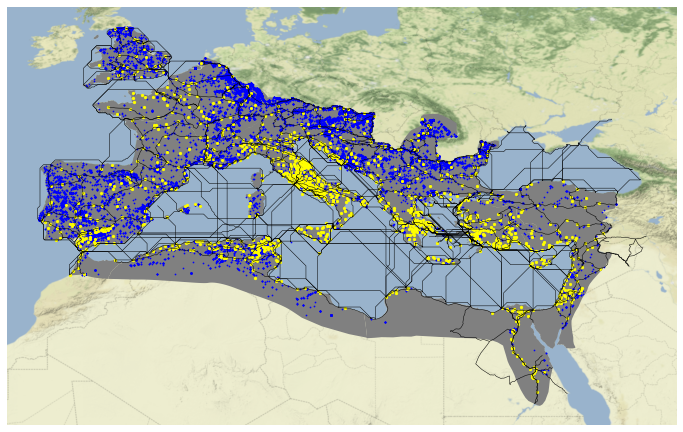

In [0]:
# Make a plot with basemap
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
provinces.plot(color="grey", ax=ax)
orbis.plot(color="black", linewidth=0.5 , ax=ax)
EDH_gdf.plot(markersize=0.5, color="blue", ax=ax) 
cities.plot(color="yellow", markersize=5, ax=ax)
ctx.add_basemap(ax=ax,  zoom=6, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326")
plt.axis("off")
plt.show()

# Distrubution of inscriptions per province

In [0]:
### DENSITY OF INSCRIPTIONS PER PROVINCE
def calculate_ins_density(row_objectid, filter_col=None, filter_value=None):
  try:
    if filter_value==None:
      ins_count = len(EDH_gdf[EDH_gdf["OBJECTID"]==row_objectid])
    else:
      EDH_filtered = EDH_gdf[EDH_gdf[filter_col].str.startswith(filter_value, na=False)]
      ins_count = len(EDH_filtered[EDH_filtered["OBJECTID"]==row_objectid])
  except:
    ins_count = 0
  try: 
    ins_dens = ins_count / provinces[provinces["OBJECTID"]==row_objectid]["AREA"].tolist()[0]
    ### ins_dens = math.log2(ins_dens) ### perhaps a logarithmized version could be more useful at some point
  except:
    ins_dens = 0
  return ins_dens

In [0]:
provinces["ins_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"]), axis=1)

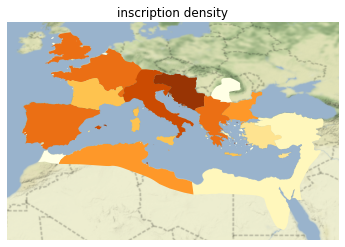

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

#vmax=provinces[provinces["ins_dens"] < provinces["ins_dens"].quantile(.98)]["ins_dens"].max() # max value without outliers
#vcenter=vmax/2
#divnorm = colors.DivergingNorm(vmin=0, vcenter=vcenter, vmax=vmax)
#cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')

provinces.plot(column="ins_dens", cmap='YlOrBr', scheme="quantiles", k=15, ax=ax) # add "norm=divnorm"
ax.set_title("inscription density")
ax.axis("off")
ctx.add_basemap(ax=ax,  zoom=4, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326") ### for basemap setting, see https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb


# Spatial distribution of different monument types

In [0]:
### what types of monument we have and how many
mon_types_counts = []
for mon_type in EDH_gdf["type_of_monument"].unique():
  if str(mon_type)[-1] != "?":
    mon_type_df = EDH_gdf[(EDH_gdf["type_of_monument"]==mon_type)|(EDH_gdf["type_of_monument"]==str(mon_type) + "?")]
    mon_type_len = len(mon_type_df)
    mon_types_counts.append([mon_type, mon_type_len])
def getKey(item):
    return item[1]
mon_types_counts = sorted(mon_types_counts, key=getKey, reverse=True)
mon_types_counts

[['tabula', 11444],
 ['altar', 8653],
 ['stele', 8356],
 ['instrumentum domesticum', 3340],
 ['statue base', 2353],
 ['block', 2223],
 ['architectural member', 1777],
 ['sarcophagus', 1575],
 ['mile-/leaguestone', 1454],
 ['tile', 1235],
 ['urn', 582],
 ['base', 560],
 ['slab', 560],
 ['relief', 527],
 ['tessera', 484],
 ['instrumentum sacrum', 443],
 ['jewellery', 387],
 ['cliff', 303],
 ['cippus', 300],
 ['honorific/grave/votive column', 267],
 ['instrumentum militare', 162],
 ['statue', 144],
 ['grave monument', 132],
 ['bar', 63],
 ['weapon', 52],
 ['table', 49],
 ['herm', 45],
 ['cupa', 41],
 ['fountain', 32],
 ['sculpture', 17],
 ['honorific/votive arch', 17],
 ['fortification', 16],
 ['diptych', 15],
 ['paving stone', 15],
 ['bench', 11],
 ['bust', 10],
 ['shield', 7],
 ['olla', 3],
 [None, 0]]

In [0]:
### lwr 
mon_types_counts[:9]

[['tabula', 11444],
 ['altar', 8653],
 ['stele', 8356],
 ['instrumentum domesticum', 3340],
 ['statue base', 2353],
 ['block', 2223],
 ['architectural member', 1777],
 ['sarcophagus', 1575],
 ['mile-/leaguestone', 1454]]

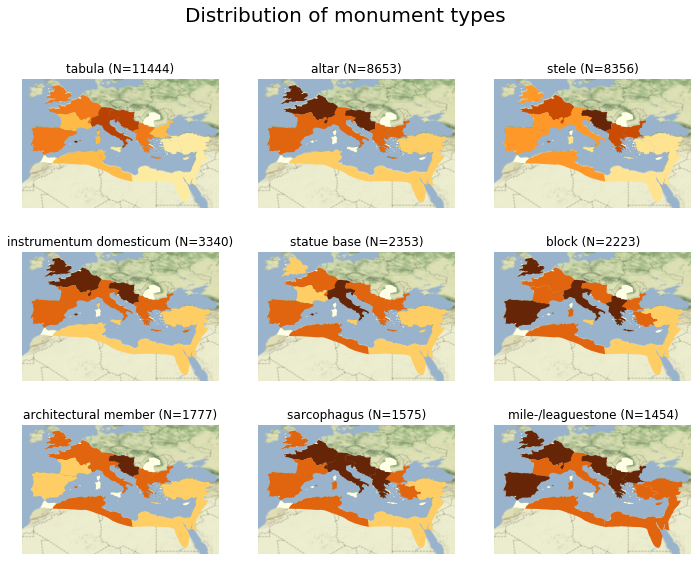

In [0]:
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
for ax, mon_type in zip(axs.ravel(), mon_types_counts[:9]):  
  provinces[mon_type[0] + "_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"], "type_of_monument", mon_type[0]), axis=1)
  provinces.plot(column=mon_type[0] + "_dens", cmap='YlOrBr', scheme="quantiles", k=15, ax=ax) 
  ax.set_title(mon_type[0] + " (N=" + str(mon_type[1]) + ")")
  ax.axis("off")
  ctx.add_basemap(ax=ax,  zoom=4, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326") ### for basemap setting, see https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb
fig.suptitle("Distribution of monument types", fontsize=20)
plt.show()

In [0]:
### save the last plotted figure locally
fig.savefig('temp.png', dpi=fig.dpi)
files.download("temp.png")

In [0]:
### AN ALTERNATIVE PARAMETRIZATION OF THE PLOT - feel free to skip
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
for ax, mon_type in zip(axs.ravel(), mon_types_counts[:9]):  
  provinces[mon_type[0] + "_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"], "type_of_monument", mon_type[0]), axis=1)
  vmax=provinces[provinces[mon_type[0] + "_dens"] < provinces[mon_type[0] + "_dens"].quantile(0.96)][mon_type[0] + "_dens"].max()
  vcenter=vmax/2
  divnorm = colors.DivergingNorm(vmin=0, vcenter=vcenter, vmax=vmax)
  cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')
  provinces.plot(column=mon_type[0] + "_dens", cmap='YlOrBr', legend=False, norm=divnorm, ax=ax) 
  ax.set_title(mon_type[0] + " (N=" + str(mon_type[1]) + ")")
  ax.axis("off")
  ctx.add_basemap(ax=ax,  zoom=4, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326") ### for basemap setting, see https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb
fig.suptitle("Distribution of monument types", fontsize=20)
plt.show()

# Spatial distribution of different inscription types

In [0]:
### extract types of inscriptions 
### and filter only for certain number of the most common
ins_types_counts = []
for ins_type in EDH_gdf["type_of_inscription"].unique():
  if str(ins_type)[-1] != "?":
    ins_type_df = EDH_gdf[(EDH_gdf["type_of_inscription"]==ins_type)|(EDH_gdf["type_of_inscription"]==str(mon_type) + "?")]
    ins_type_len = len(ins_type_df)
    ins_types_counts.append([ins_type, ins_type_len])
def getKey(item):
    return item[1]
ins_types_counts = sorted(ins_types_counts, key=getKey, reverse=True)
ins_types_counts

[['epitaph', 23437],
 ['votive inscription', 11498],
 ['owner/artist inscription', 3603],
 ['honorific inscription', 3075],
 ['building/dedicatory inscription', 2380],
 ['mile-/leaguestone', 1407],
 ['identification inscription', 1015],
 ['acclamation', 414],
 ['defixio', 277],
 ['military diploma', 274],
 ['list', 268],
 ['label', 200],
 ['boundary inscription', 195],
 ['public legal inscription', 162],
 ['elogium', 82],
 ['letter', 71],
 ['prayer', 45],
 ['seat inscription', 29],
 ['private legal inscription', 23],
 ['assignation inscription', 13],
 ['calendar', 9],
 ['adnuntiatio', 3],
 [None, 0]]

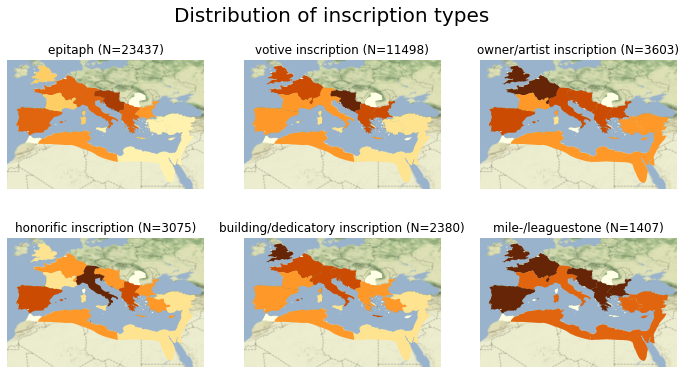

In [0]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, ins_type in zip(axs.ravel(), ins_types_counts[:6]):  
  provinces[ins_type[0] + "_dens"] = provinces.apply(lambda row: calculate_ins_density(row["OBJECTID"], "type_of_inscription", ins_type[0]), axis=1)
  provinces.plot(column=ins_type[0] + "_dens", cmap='YlOrBr', scheme="quantiles", k=15, legend=False, ax=ax) 
  ax.set_title(ins_type[0] + " (N=" + str(ins_type[1]) + ")")
  ax.axis("off")
  ctx.add_basemap(ax=ax,  zoom=4, url=getattr(ctx.sources, "ST_TERRAIN_BACKGROUND"), crs="epsg:4326") ### for basemap setting, see https://github.com/darribas/contextily/blob/master/contextily_guide.ipynb
fig.suptitle("Distribution of inscription types", fontsize=20)
plt.show()

In [0]:
### save the last plotted figure locally
fig.savefig('temp.png', dpi=fig.dpi)
files.download("temp.png")